<a href="https://colab.research.google.com/github/VMI1997/UCB-Module-20/blob/main/Mod20_Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Introduction:**

**Problem Statement:**  The loss of customers is a costly issues for banks that depend on customer deposits to support lending.  Further, the cost of acquiring new customers to account for lost customers is very expensive and detrimental to the business of banking.   For these reasons, having a model to predict customer attrition is of high importance.  Having such a model would allow the bank to proactively target customers at risk of attrition and apply retention techniques to mitigate attrition risk.

**Explanation of Approach:**  In this exercise, we are going to leverage readily available data about a portion of our bank customers - both those that have attrited and those that remain.   We are going to use this data to build a simplistic model with the goal of predicting those customers that are likely to attrite.  We are goign to begin with a logistic regression model for this purpose and apply the techniques used in our coursework thus far.

**Import Packages that will be needed for this Project**

In [112]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

**Import customer data from CSV (fully anonymized data - no sensitive data exists within)**

In [113]:

cust_data = pd.read_csv('cust_data.csv')
cust_data.head()


,row_number_acct,application_code,opened_month_end_date,closed_ind,closed_month_end_date,event_month,months_open,event_month_branch_number,event_month_product_code,event_month_product_description,...,prior_month_3_online_banking_flag,prior_month_4_online_banking_flag,prior_month_5_online_banking_flag,prior_month_6_online_banking_flag,prior_month_1_e_statement_flag,prior_month_2_e_statement_flag,prior_month_3_e_statement_flag,prior_month_4_e_statement_flag,prior_month_5_e_statement_flag,prior_month_6_e_statement_flag
0,1,DD,1/31/2006,NaN,NaN,12/31/2024,227,753,I,INTEREST CHECKING,...,N,N,N,N,Y,Y,Y,Y,Y,Y
1,2,DD,4/30/2019,NaN,NaN,12/31/2024,68,781,N,FREE CHECKING,...,Y,Y,Y,Y,N,N,N,N,N,N
2,3,DD,3/31/2017,NaN,NaN,12/31/2024,93,702,I,INTEREST CHECKING,...,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y
3,4,DD,10/31/2013,NaN,NaN,12/31/2024,134,13,N,FREE CHECKING,...,N,N,N,N,N,N,N,N,N,N
4,5,DD,4/30/2021,NaN,NaN,12/31/2024,44,604,N,FREE CHECKING,...,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y


**Data Analysis and Visualizations**


*   Basic data analysis around fields, values and quality - general understanding of the data available
*   Examine key fields that are anticipated to be key drivers of attrition (fees/refunds, tenure, direct deposit, average balances, online banking)

**Key Findings:**


*   There are 41,352 customer records within this dataset (this is a subset of the total data set that we assume is representative)
*   There are 12,010 records for closed accounts - the remainder are for accounts that remained open at this snapshot
*   There are a number of "flag" fields that will need to be manipulated
*   There are a number of "snapshot" fields that reflect values for a 6 month period prior to closure/snapshot - we will likely want to look at most recent and/or "deltas" between these to see how they "change"
*   There are a number of NaN values that we will need to deal with in our data preparation
*   List item










In [114]:
cust_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41352 entries, 0 to 41351
Data columns (total 65 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   row_number_acct                     41352 non-null  int64  
 1   application_code                    41352 non-null  object 
 2   opened_month_end_date               41352 non-null  object 
 3   closed_ind                          12010 non-null  float64
 4   closed_month_end_date               12010 non-null  object 
 5   event_month                         41352 non-null  object 
 6   months_open                         41352 non-null  int64  
 7   event_month_branch_number           41352 non-null  int64  
 8   event_month_product_code            41352 non-null  object 
 9   event_month_product_description     41352 non-null  object 
 10  event_month_product_category        41352 non-null  object 
 11  prior_month_1_to_event_date         41352

In [115]:
cust_data['closed_ind'].value_counts()

,count
closed_ind,
1.0,12010


In [116]:
nan_count = cust_data.isna().sum()

print(nan_count)

row_number_acct                       0
application_code                      0
opened_month_end_date                 0
closed_ind                        29342
closed_month_end_date             29342
                                  ...  
prior_month_2_e_statement_flag       22
prior_month_3_e_statement_flag      692
prior_month_4_e_statement_flag     1208
prior_month_5_e_statement_flag     1755
prior_month_6_e_statement_flag     2497
Length: 65, dtype: int64


**Data Preparation:**

Based on our initial analysis and understanding of the data, we will now prepare the data prior to digging deeper into visualizations.
The following steps were taken:


*   Drop a number of fields not needed (Step 1 below)
*   Populate the NaN values - in all cases, we can update to zero safely
*   Create summary columns for total fees, total refunds, percentage of fees refunded, average balance changes; binary flag for direct deposit being present, binary flag for online banking being present (after which we drop the component columns used to build summary)
*   Create one-hot encoding for product types





In [117]:
#Step 1 - Drop Fields NOT to be used
cust_data_temp = cust_data
cust_data_temp = cust_data_temp.drop(['application_code','opened_month_end_date','closed_month_end_date','event_month_product_code','event_month_product_category','prior_month_1_to_event_date',
                                     'prior_month_2_to_event_date','prior_month_3_to_event_date','prior_month_4_to_event_date','prior_month_5_to_event_date','prior_month_6_to_event_date',
                                     'prior_month_1_interest_rate','prior_month_2_interest_rate','prior_month_3_interest_rate','prior_month_4_interest_rate','prior_month_5_interest_rate',
                                     'prior_month_6_interest_rate','prior_month_2_online_banking_flag','prior_month_3_online_banking_flag','prior_month_4_online_banking_flag',
                                     'prior_month_5_online_banking_flag','prior_month_6_online_banking_flag','prior_month_1_e_statement_flag','prior_month_2_e_statement_flag',
                                     'prior_month_3_e_statement_flag','prior_month_4_e_statement_flag','prior_month_5_e_statement_flag','prior_month_6_e_statement_flag'], axis=1)
#Step 2 - REmediate the NaN values
cust_data_temp.fillna(0, inplace=True)
#cust_data_temp.info()

#Step 3 - Create Summary Columns
cust_data_temp['total_fees'] = (cust_data_temp['prior_month_1_fee_total'] + cust_data_temp['prior_month_2_fee_total'] + cust_data_temp['prior_month_3_fee_total'] +
                                cust_data_temp['prior_month_4_fee_total'] + cust_data_temp['prior_month_5_fee_total'] + cust_data_temp['prior_month_6_fee_total'])
cust_data_temp['total_refunds'] = (cust_data_temp['prior_month_1_fee_refund_total'] + cust_data_temp['prior_month_2_fee_refund_total'] + cust_data_temp['prior_month_3_fee_refund_total'] +
                                cust_data_temp['prior_month_4_fee_refund_total'] + cust_data_temp['prior_month_5_fee_refund_total'] + cust_data_temp['prior_month_6_fee_refund_total'])
cust_data_temp['total_fee_refund_pct'] = cust_data_temp['total_refunds'] / (abs(cust_data_temp['total_fees']) + cust_data_temp['total_refunds'])
cust_data_temp.loc[cust_data_temp['total_fee_refund_pct'].isna(), 'total_fee_refund_pct'] = 0
cust_data_temp['avg_bal_change'] = cust_data_temp['prior_month_1_average_balance'] - cust_data_temp['prior_month_2_average_balance']
cust_data_temp['has_direct_dep'] = 0
cust_data_temp.loc[cust_data_temp['prior_month_1_direct_deposit_total'] > 0, 'has_direct_dep'] = 1
#Step 4 - Convert boolean to 0 and 1
cust_data_temp['prior_month_1_online_banking_flag'] = cust_data_temp['prior_month_1_online_banking_flag'].map({'Y': 1, 'N': 0})


#Step 5 - Apply One-Hot Encoding
cust_data_temp = pd.get_dummies(cust_data_temp, columns=['event_month_product_description'])
cust_data_temp.head()

#Step 6 - Drop Remaining Columns not used
cust_data_temp.drop(['event_month','event_month_branch_number','prior_month_2_direct_deposit_total','prior_month_3_direct_deposit_total','prior_month_4_direct_deposit_total','prior_month_5_direct_deposit_total',
                     'prior_month_6_direct_deposit_total','prior_month_1_fee_total','prior_month_2_fee_total','prior_month_3_fee_total','prior_month_4_fee_total',
                     'prior_month_5_fee_total','prior_month_6_fee_total','prior_month_1_fee_refund_total','prior_month_2_fee_refund_total','prior_month_3_fee_refund_total',
                     'prior_month_4_fee_refund_total','prior_month_5_fee_refund_total','prior_month_6_fee_refund_total','prior_month_2_average_balance',
                     'prior_month_3_average_balance','prior_month_4_average_balance','prior_month_5_average_balance','prior_month_6_average_balance',
                     'prior_month_1_od_nsf_items','prior_month_2_od_nsf_items','prior_month_3_od_nsf_items','prior_month_4_od_nsf_items','prior_month_5_od_nsf_items',
                     'prior_month_6_od_nsf_items'],axis=1, inplace=True)

cust_data_temp.fillna(0, inplace=True)

cust_data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41352 entries, 0 to 41351
Data columns (total 29 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   row_number_acct                                          41352 non-null  int64  
 1   closed_ind                                               41352 non-null  float64
 2   months_open                                              41352 non-null  int64  
 3   prior_month_1_direct_deposit_total                       41352 non-null  float64
 4   prior_month_1_average_balance                            41352 non-null  int64  
 5   prior_month_1_online_banking_flag                        41352 non-null  float64
 6   total_fees                                               41352 non-null  float64
 7   total_refunds                                            41352 non-null  float64
 8   total_fee_refund_pct      

**Data Visualizations and Analysis**

**Open and Closed Accounts**

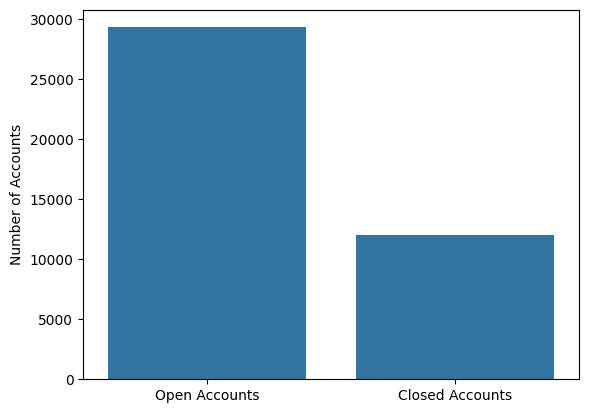

In [118]:
plot = sns.countplot(x='closed_ind', data=cust_data_temp)

# Customize x-axis labels
new_labels = ['Open Accounts','Closed Accounts']
plot.set_xticklabels(new_labels)
plt.xlabel('')
plt.ylabel('Number of Accounts')
plt.show()

**Fees & Refunds for Closures**


*   As expected, the total fees assigned to closed accounts is substantially higher than for accounts that remained open (approx. 3X rate)
*   What is not expected is that the rate of fees refunded is substantially higher for closed accounts on a % basis



In [119]:
cust_data_temp.groupby('closed_ind')['total_fees'].mean()


,total_fees
closed_ind,
0.0,-34.683110
1.0,-107.637566


In [120]:
cust_data_temp.groupby('closed_ind')['total_fee_refund_pct'].mean()


,total_fee_refund_pct
closed_ind,
0.0,0.007003
1.0,0.019535


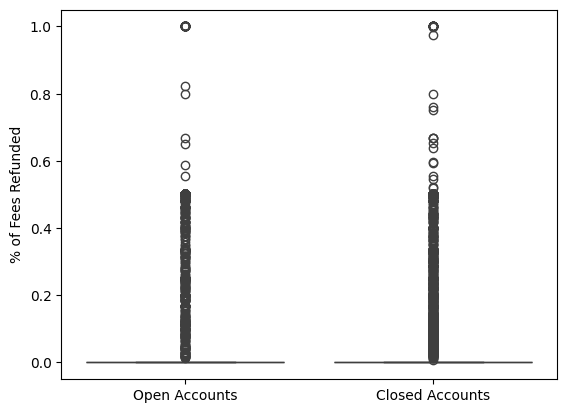

In [121]:
plot = sns.boxplot(x='closed_ind', y='total_fee_refund_pct', data=cust_data_temp)
new_labels = ['Open Accounts','Closed Accounts']
plot.set_xticklabels(new_labels)
plt.ylabel('% of Fees Refunded')
plt.xlabel('')
plt.show()

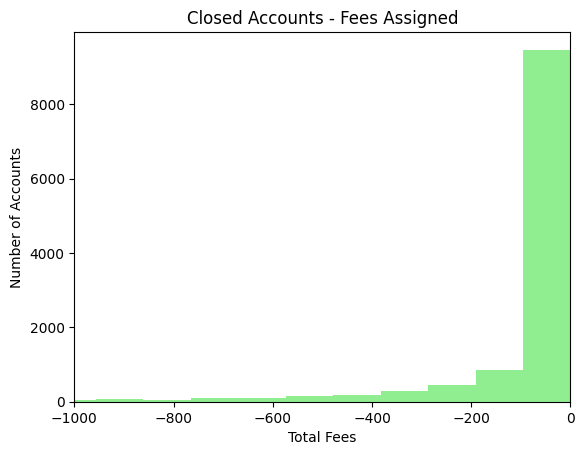

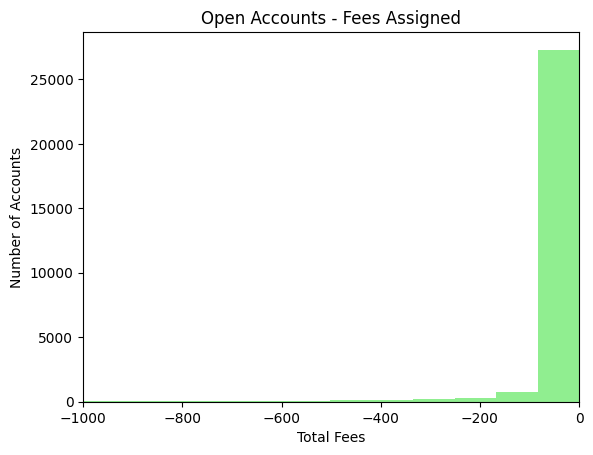

In [122]:
plt.hist(cust_data_temp.query("closed_ind == 1")['total_fees'], color='lightgreen', ec='black', bins=50)
plt.xlim(-1000, 0)
plt.ylabel('Number of Accounts')
plt.xlabel('Total Fees')
plt.title('Closed Accounts - Fees Assigned')
plt.show()
plt.hist(cust_data_temp.query("closed_ind == 0")['total_fees'], color='lightgreen', ec='black', bins=50)
plt.xlim(-1000, 0)
plt.ylabel('Number of Accounts')
plt.xlabel('Total Fees')
plt.title('Open Accounts - Fees Assigned')
plt.show()


**Tenure of Accounts**


*   The assumption is that longer tenure accounts are less likely to close and there seems to be some grounding behind that assertion



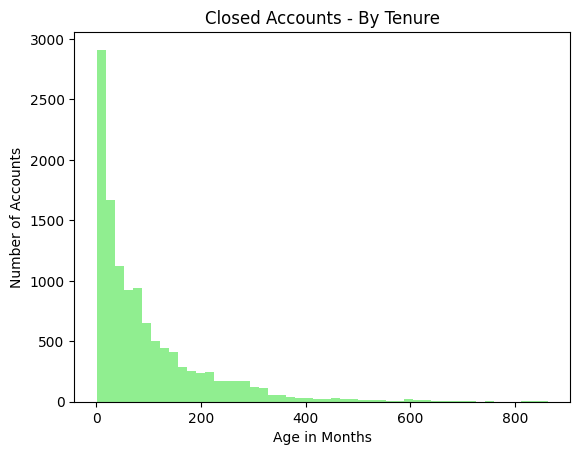

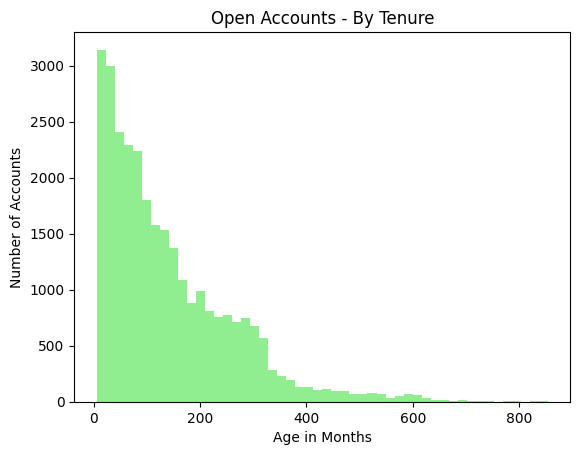

In [123]:
plt.hist(cust_data_temp.query("closed_ind == 1")['months_open'], color='lightgreen', ec='black', bins=50)

plt.ylabel('Number of Accounts')
plt.xlabel('Age in Months')
plt.title('Closed Accounts - By Tenure')
plt.show()
plt.hist(cust_data_temp.query("closed_ind == 0")['months_open'], color='lightgreen', ec='black', bins=50)

plt.ylabel('Number of Accounts')
plt.xlabel('Age in Months')
plt.title('Open Accounts - By Tenure')
plt.show()

**Direct Deposit **

*   There is a 3X rate of customers remaining open having direct deposit - it would appear that NOT having direct deposit can influence likelihood to close the account


In [124]:
dd_for_open = cust_data_temp.query("closed_ind == 0")['has_direct_dep'].sum() / len(cust_data_temp.query("closed_ind == 0"))
dd_for_closed = cust_data_temp.query("closed_ind == 1")['has_direct_dep'].sum() / len(cust_data_temp.query("closed_ind == 1"))
print("The % of open accounts with direct deposit is: " + str(dd_for_open))
print("The % of closed accounts with direct deposit is: " + str(dd_for_closed))

The % of open accounts with direct deposit is: 0.602378842614682
The % of closed accounts with direct deposit is: 0.21723563696919235


**Customer Balances**

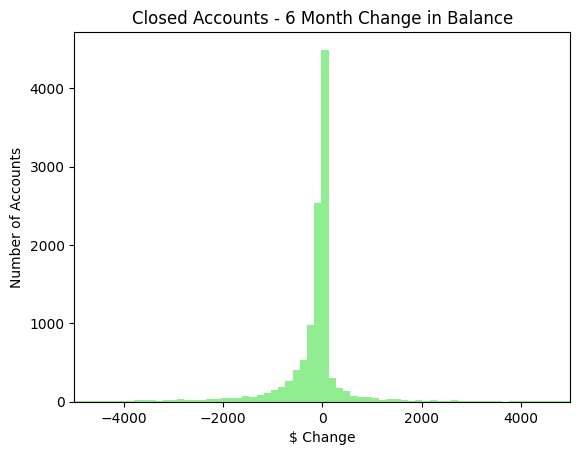

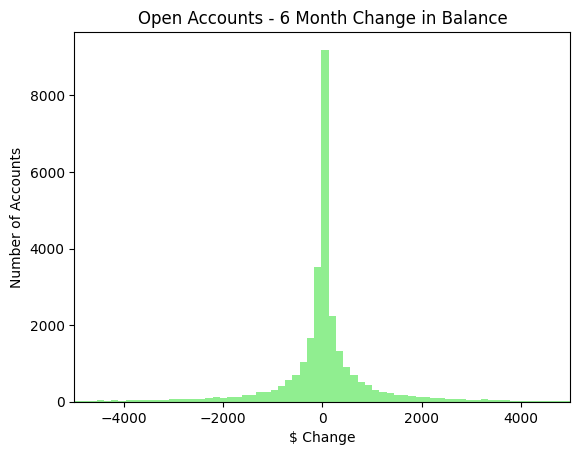

In [125]:
plt.hist(cust_data_temp.query("closed_ind == 1")['avg_bal_change'], color='lightgreen', ec='black', bins=5000)

plt.ylabel('Number of Accounts')
plt.xlabel('$ Change')
plt.title('Closed Accounts - 6 Month Change in Balance')
plt.xlim(-5000, 5000)
plt.show()
plt.hist(cust_data_temp.query("closed_ind == 0")['avg_bal_change'], color='lightgreen', ec='black', bins=5000)
plt.ylabel('Number of Accounts')
plt.xlabel('$ Change')
plt.xlim(-5000, 5000)
plt.title('Open Accounts - 6 Month Change in Balance')
plt.show()

**Presence of Online Banking**

*   The presence of online banking does not appear to be as substantial a driver of customer closure as expected




In [126]:
ob_for_open = cust_data_temp.query("closed_ind == 0")['prior_month_1_online_banking_flag'].sum() / len(cust_data_temp.query("closed_ind == 0"))
ob_for_closed = cust_data_temp.query("closed_ind == 1")['prior_month_1_online_banking_flag'].sum() / len(cust_data_temp.query("closed_ind == 1"))
print("The % of open accounts with direct deposit is: " + str(ob_for_open))
print("The % of closed accounts with direct deposit is: " + str(ob_for_closed))

The % of open accounts with direct deposit is: 0.7682502896871379
The % of closed accounts with direct deposit is: 0.790924229808493


**Creation of First Simple Model**


*   The initial model chosen for this was logistic regression.  I chose this model because of it's simplicity and interpretability.  The latter will be most important because it will be needed to drive "actions" to mitigate the risk of attrition which is the ultimate goal
*   An initial accuracy of  66.4% was achieved and is a pretty solid initial result without any additional fine tuning performed.
*   Additionally, when looking at the confusion matrix, it is also important to note that the real "risk" population are those that we "predicted" would not attrite that DID...the risk of predicting an attrite when it DIDN'T happen is lower risk because the actions we would take proactively would likely be no regret moves for that population
*   List item





Mean Squared Error: 0.33635594244952244
R-squared: -0.6322175151081717
Accuracy Score: 0.6636440575504776


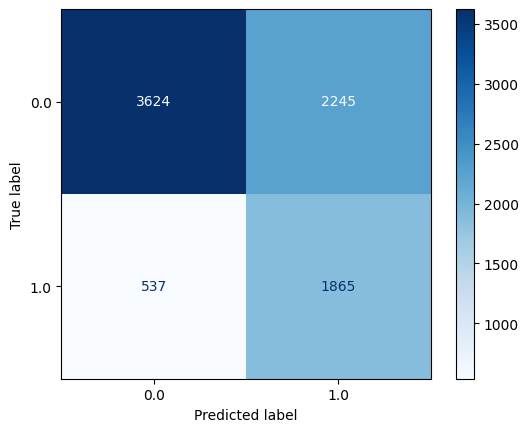

In [127]:
#Create simple model

#Create features and target
X = cust_data_temp.drop('closed_ind', axis=1)
y = cust_data_temp['closed_ind']

#Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
#Look at stratify parameter - stratify=target

#Create Linear Regression Model and Fit
log_reg = LogisticRegression(max_iter=10000, class_weight='balanced')
log_reg.fit(X_train, y_train)

#Make predictions on the test set
y_pred = log_reg.predict(X_test)

#Calculate Accuracy Metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
acc_score = log_reg.score(X_test, y_test)

print("Mean Squared Error:", mse)
print("R-squared:", r2)
print("Accuracy Score:", acc_score)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot(cmap='Blues')

In [128]:
from sklearn.feature_selection import RFE

# Fit the model
model = LinearRegression()
rfe = RFE(model, n_features_to_select=1)
rfe.fit(X_train, y_train)

# Get the ranking of features
ranking = pd.DataFrame(rfe.ranking_, X.columns, columns=['Ranking'])
print(ranking)

                                                    Ranking
row_number_acct                                          23
months_open                                              21
prior_month_1_direct_deposit_total                       24
prior_month_1_average_balance                            26
prior_month_1_online_banking_flag                        10
total_fees                                               22
total_refunds                                            19
total_fee_refund_pct                                      1
avg_bal_change                                           25
has_direct_dep                                            2
event_month_product_description_ADVANTAGE MONEY...        3
event_month_product_description_ALUMNI CHECKING           6
event_month_product_description_BANK OWNED OPER...       27
event_month_product_description_BUSINESS CHECKING        28
event_month_product_description_FREE CHECKING            15
event_month_product_description_INTEREST